# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats
import pandas as pd

In [2]:
var='TSKIN'

In [3]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')

In [4]:
from load_ensembles import *

In [5]:
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

# Load data

### Load gridcell info

In [6]:
from load_gridcell_areas import *

### Load and check reference cases

In [7]:
basecase_lnd_coupled=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.h0.timeseries.'+var+'.nc')

In [8]:
basecase_lnd_offline=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/OFFL0000_PI_v02/lnd/proc/tseries/OFFL0000_PI_v02.clm2.h0.timeseries.'+var+'.nc')

In [9]:
print(basecase_lnd_offline.time)
print('--------------------------------')
print(basecase_lnd_coupled.time)

<xarray.DataArray 'time' (time: 1680)>
array([cftime.DatetimeNoLeap(49, 1, 16, 11, 44, 59, 972534, 1, 16),
       cftime.DatetimeNoLeap(49, 2, 15, 0, 0, 0, 0, 3, 46),
       cftime.DatetimeNoLeap(49, 3, 16, 12, 0, 0, 0, 4, 75), ...,
       cftime.DatetimeNoLeap(188, 10, 16, 12, 0, 0, 0, 0, 289),
       cftime.DatetimeNoLeap(188, 11, 16, 0, 0, 0, 0, 3, 320),
       cftime.DatetimeNoLeap(188, 12, 16, 12, 0, 0, 0, 5, 350)], dtype=object)
Coordinates:
  * time     (time) object 0049-01-16 11:44:59 ... 0188-12-16 12:00:00
Attributes:
    long_name:     time
    bounds:        time_bounds
    cell_methods:  time: mean
    NCL:           function time_reassign used to reassign time to mid-value ...
--------------------------------
<xarray.DataArray 'time' (time: 1680)>
array([cftime.DatetimeNoLeap(49, 1, 16, 12, 0, 0, 0, 1, 16),
       cftime.DatetimeNoLeap(49, 2, 15, 0, 0, 0, 0, 3, 46),
       cftime.DatetimeNoLeap(49, 3, 16, 12, 0, 0, 0, 4, 75), ...,
       cftime.DatetimeNoLeap(188, 10, 16

In [10]:
offline_tseries=(basecase_lnd_offline[var]*landweights).mean(dim=['lat','lon']).groupby('time.year').mean(dim='time')

In [11]:
coupled_tseries=(basecase_lnd_coupled[var]*landweights).mean(dim=['lat','lon']).groupby('time.year').mean(dim='time')

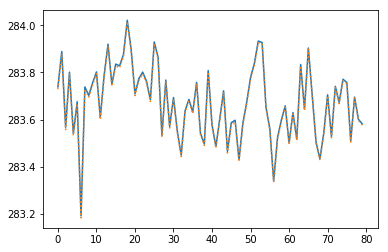

In [12]:
plt.plot(coupled_tseries[60:])
plt.plot(offline_tseries[60:],':')

### Load ensemble data

In [13]:
ensemble_coupled=load_coupled_ensemble(var=var, domain='lnd')
ensemble_offline=load_offline_ensemble(var=var, domain='lnd')

In [14]:
ensemble_coupled.append(basecase_lnd_coupled)
ensemble_offline.append(basecase_lnd_offline)

In [15]:
[lons,lats] = np.meshgrid(basecase_lnd_offline.lon,basecase_lnd_offline.lat)

# Look at distribution of offline temperature patterns

In [16]:
ref=basecase_lnd_offline[var][60*12:,:,:].mean(dim='time')
temp_delta_distributions_offline=[]
for i, ensemble_data in enumerate(ensemble_offline):
    ds=ensemble_offline[i][var][60*12:,:,:].mean(dim='time')
    diff=ds-ref
    diff_flat=diff.values.flatten()
    diff_flat_nonan=diff_flat[~np.isnan(diff_flat)]
    temp_delta_distributions_offline.append(diff_flat_nonan)

In [17]:
ref=basecase_lnd_coupled[var][60*12:,:,:].mean(dim='time')
temp_delta_distributions_coupled=[]
for i, ensemble_data in enumerate(ensemble_coupled):
    ds=ensemble_coupled[i][var][60*12:,:,:].mean(dim='time')
    diff=ds-ref
    diff_flat=diff.values.flatten()
    diff_flat_nonan=diff_flat[~np.isnan(diff_flat)]
    temp_delta_distributions_coupled.append(diff_flat_nonan)

In [18]:
lons_flat=lons.flatten()
lons_flat_nonan=lons_flat[~np.isnan(diff_flat)]
lats_flat=lats.flatten()
lats_flat_nonan=lats_flat[~np.isnan(diff_flat)]

In [19]:
#latfilter=(lats_flat_nonan<20)&(lats_flat_nonan>-20)
#latfilter=(lats_flat_nonan<30)&(lats_flat_nonan<60)
latfilter=(lats_flat_nonan<1000)

In [46]:
#latfilter=(lats_flat_nonan<20)&(lats_flat_nonan>-20)
latfilter=(lats_flat_nonan>-1000)
offline_pct_below_0=[]
for i, ensemble_data in enumerate(temp_delta_distributions_offline[:-1]):
    pct_below_0=stats.percentileofscore(temp_delta_distributions_offline[i][latfilter],0)
    offline_pct_below_0.append(pct_below_0)

In [47]:
latfilter=(lats_flat_nonan>-1000)
coupled_pct_below_0=[]
for i, ensemble_data in enumerate(temp_delta_distributions_coupled[:-1]):
    pct_below_0=stats.percentileofscore(temp_delta_distributions_coupled[i][latfilter],0)
    coupled_pct_below_0.append(pct_below_0)

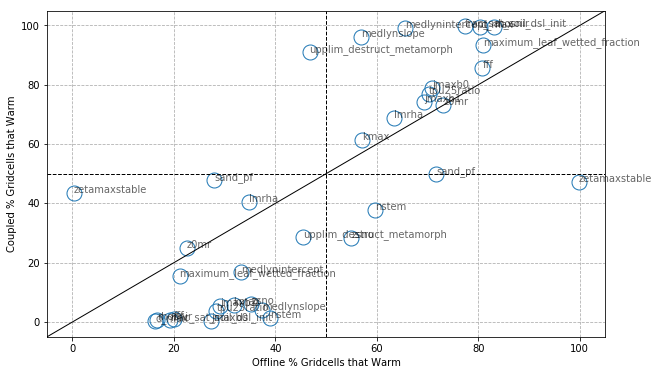

In [48]:
plt.figure(figsize=(10,6))
plt.plot(np.array(offline_pct_below_0),
         np.array(coupled_pct_below_0),'o', markersize=15,fillstyle='none')
plt.grid(linestyle='--')
plt.plot([-5,105],[-5,105],'-k', linewidth=1)
plt.axhline(y=50,color='k',linestyle='--',linewidth=1)
plt.axvline(x=50,color='k',linestyle='--',linewidth=1)
plt.xlabel('Offline % Gridcells that Warm')
plt.ylabel('Coupled % Gridcells that Warm')
plt.xlim([-5,105])
plt.ylim([-5,105])
for i,param in enumerate(crosswalk.param.values):
    plt.annotate(param,
             (offline_pct_below_0[i],
              coupled_pct_below_0[i]),alpha=0.6)
plt.savefig('Gridcell_pct_warming.png')

### Figures

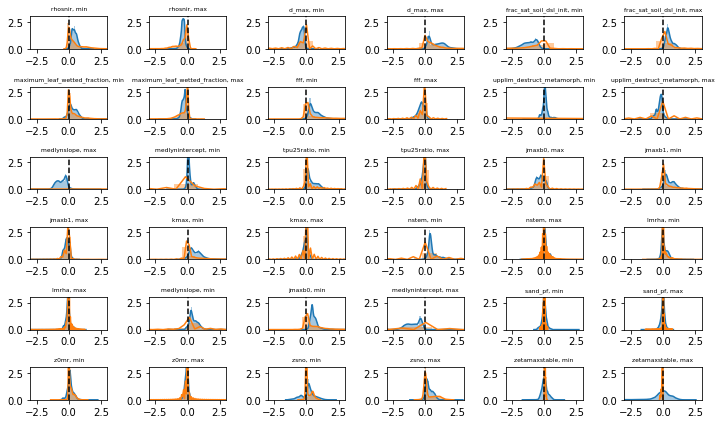

In [49]:
plt.figure(figsize=(10,6))
for i, ensemble_data in enumerate(temp_delta_distributions_coupled[:-1]):
    plt.subplot(6,6,i+1)
    mean_temp_coupled = np.nanmean(temp_delta_distributions_coupled[i])
    mean_temp_offline = np.nanmean(temp_delta_distributions_offline[i])
    sns.distplot(temp_delta_distributions_coupled[i])
    sns.distplot(temp_delta_distributions_offline[i]*mean_temp_coupled/mean_temp_offline)
    plt.xlim([-3,3])
    plt.ylim([0,3])
    plt.axvline(x=0, linestyle='--', color='k')
    plt.title(crosswalk.description.values[i], fontsize=6)
plt.tight_layout()

4.287704162597656
0.6464385986328125
1.738765411376953
1.603271255493164
1.015842742919922
3.4504345703125
0.8827101898193359
0.6431362152099609
2.0432359313964845
0.1609576416015625
2.5938644409179688
1.2467765808105469
1.5822568893432618
2.1313698577880857
1.295136260986328
1.1588793945312499
2.1081429290771485
2.620804748535156
0.5260041809082031
2.3911368560791018
0.7407933807373047
1.9411976623535157
0.7551339721679687
1.4067214202880858
1.2398226928710936
2.187370834350586
1.403917007446289
0.3973350524902344
2.7857315826416014
0.9140581512451172
1.2765635681152345
0.8681671142578126
1.567802734375
1.4064210128784178
1.301741714477539
1.4237285614013673


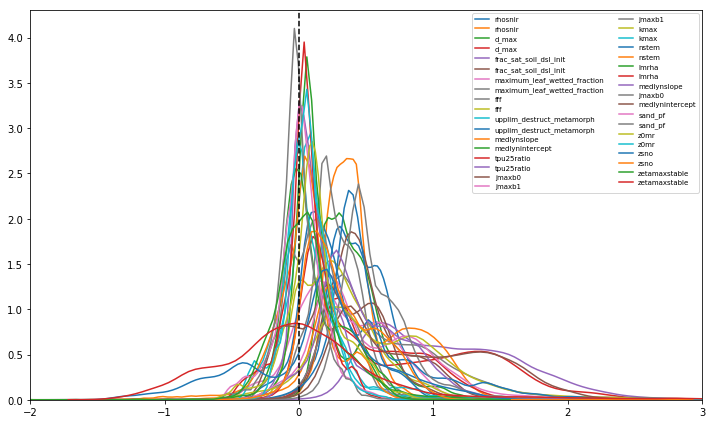

In [77]:
plt.figure(figsize=(10,6))
for i, ensemble_data in enumerate(temp_delta_distributions[:-1]):
    mean_temp = np.nanmean(temp_delta_distributions[i])
    label=crosswalk.param.values[i]
    print(pct_95)
    pct_95=np.max([np.abs(np.percentile(temp_delta_distributions[i],0.95)),
                   np.abs(np.percentile(temp_delta_distributions[i],0.05))])
    if mean_temp>0:
        if pct_95<0.5:
            sns.distplot(temp_delta_distributions[i], hist=False, color='gray', label=label)
        else:
            sns.distplot(temp_delta_distributions[i], hist=False, label=label)
    else:
        if pct_95<0.5:
            sns.distplot(temp_delta_distributions[i], hist=False, color='gray', label=label)
        else:
            sns.distplot(-temp_delta_distributions[i], hist=False, label=label)
plt.xlim([-2,3])
plt.axvline(x=0, linestyle='--', color='k')
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()

rhosnir
rhosnir
d_max
d_max
frac_sat_soil_dsl_init
frac_sat_soil_dsl_init
maximum_leaf_wetted_fraction
maximum_leaf_wetted_fraction
fff
fff
upplim_destruct_metamorph
upplim_destruct_metamorph
medlynslope
medlynintercept
tpu25ratio
tpu25ratio
jmaxb0
jmaxb1
jmaxb1
kmax
kmax
nstem
nstem
lmrha
lmrha
medlynslope
jmaxb0
medlynintercept
sand_pf
sand_pf
z0mr
z0mr
zsno
zsno
zetamaxstable
zetamaxstable


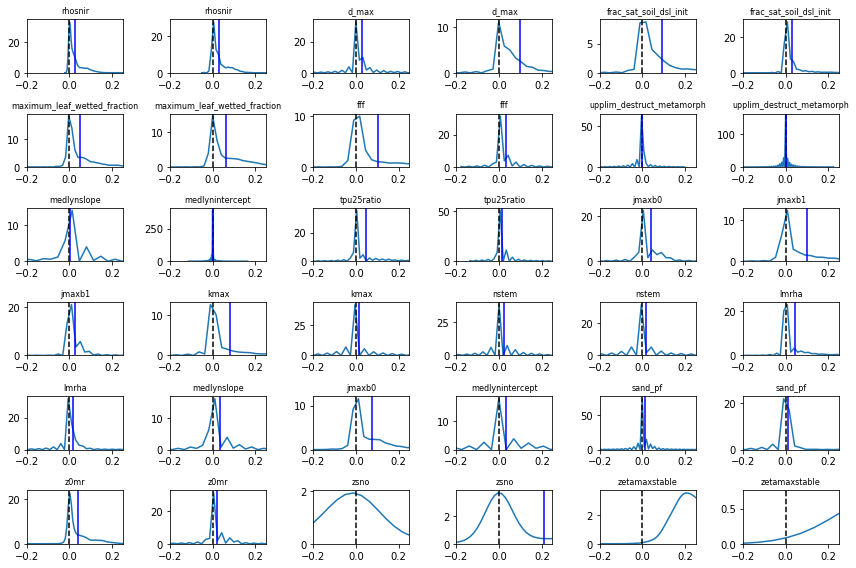

In [42]:
plt.figure(figsize=(12,8))
offline_pct_below_0=[]
for i, ensemble_data in enumerate(temp_delta_distributions[:-1]):
    mean_temp = np.nanmean(temp_delta_distributions[i])
    label=crosswalk.param.values[i]
    print(label)
    plt.subplot(6,6,i+1)
    if mean_temp>0:
        sns.distplot(temp_delta_distributions[i], hist=False)
        #print(np.round(np.percentile(temp_delta_distributions[i],10),2))
        pct_below_0=stats.percentileofscore(temp_delta_distributions[i],0)
    else:
        sns.distplot(-temp_delta_distributions[i], hist=False)
        pct_below_0=stats.percentileofscore(-temp_delta_distributions[i],0)
        #print(np.round(np.percentile(-temp_delta_distributions[i],10),2))
    plt.title(label, fontsize=8)
    plt.xlim([-0.2,0.25])
    plt.axvline(x=0, linestyle='--', color='k')
    plt.axvline(x=np.abs(mean_temp), linestyle='-', color='b')
    offline_pct_below_0.append(pct_below_0)
plt.tight_layout()

In [48]:
coupled_pct_below_0=coupled_pct_below_0[0:36]

rhosnir
rhosnir
d_max
d_max
frac_sat_soil_dsl_init
frac_sat_soil_dsl_init
maximum_leaf_wetted_fraction
maximum_leaf_wetted_fraction
fff
fff
upplim_destruct_metamorph
upplim_destruct_metamorph
medlynslope
medlynintercept
tpu25ratio
tpu25ratio
jmaxb0
jmaxb1
jmaxb1
kmax
kmax
nstem
nstem
lmrha
lmrha
medlynslope
jmaxb0
medlynintercept
sand_pf
sand_pf
z0mr
z0mr
zsno
zsno
zetamaxstable
zetamaxstable


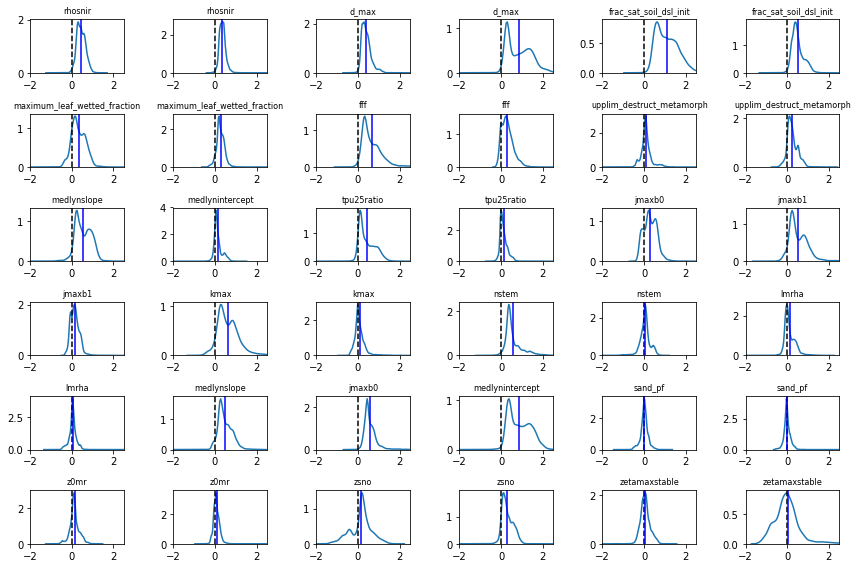

In [35]:
plt.figure(figsize=(12,8))
coupled_pct_below_0=[]
for i, ensemble_data in enumerate(temp_delta_distributions[:-1]):
    mean_temp = np.nanmean(temp_delta_distributions[i])
    label=crosswalk.param.values[i]
    print(label)
    plt.subplot(6,6,i+1)
    if mean_temp>0:
        sns.distplot(temp_delta_distributions[i], hist=False)
        #print(np.round(np.percentile(temp_delta_distributions[i],10),2))
        pct_below_0=stats.percentileofscore(temp_delta_distributions[i],0)
    else:
        sns.distplot(-temp_delta_distributions[i], hist=False)
        pct_below_0=stats.percentileofscore(-temp_delta_distributions[i],0)
        #print(np.round(np.percentile(-temp_delta_distributions[i],10),2))
    plt.title(label, fontsize=8)
    plt.xlim([-2,2.5])
    plt.axvline(x=0, linestyle='--', color='k')
    plt.axvline(x=np.abs(mean_temp), linestyle='-', color='b')
    coupled_pct_below_0.append(pct_below_0)
plt.tight_layout()

In [ ]:
plt.subplot(6,6,i+1)
plt.pcolormesh((var_array_pvals<0.05)[:,:,i])
plt.tight_layout()

# Other analysis

# Process data

### Get landweights

In [18]:
landweights_NHmidlat=subset_landweights(latmax=60, latmin=30)
landweights_NHhighlat=subset_landweights(latmax=95, latmin=45)
landweights_tropics=subset_landweights(latmax=20, latmin=-20)
landweights_10deg=subset_landweights(latmin=30,latmax=40)

# Make IAV and mean plots for global totals

### Do calculations

In [37]:
global_iav_coupled = []
global_mean_coupled = []
global_coeffvar_coupled = []

for i, ds in enumerate(ensemble_coupled):
    if ds is not None:
        #ds_annual_global=calculate_sum(ds[var])
        ds_annual_global=calculate_mean(ds[var],landweights=landweights)
        ds_std=ds_annual_global.std(dim='year').values
        ds_mean=ds_annual_global.mean(dim='year').values
    else:
        ds_std=np.nan
        ds_mean=np.nan
    global_iav_coupled.append(ds_std)
    global_mean_coupled.append(ds_mean)
    global_coeffvar_coupled.append(ds_std/ds_mean)

In [38]:
global_iav_offline = []
global_mean_offline = []
global_coeffvar_offline = []
for i, ds in enumerate(ensemble_offline):
    if ds is not None:
        #ds_annual_global=calculate_sum(ds[var])
        ds_annual_global=calculate_mean(ds[var],landweights=landweights)
        ds_std=ds_annual_global.std(dim='year').values
        ds_mean=ds_annual_global.mean(dim='year').values
    else:
        ds_std=np.nan
        ds_mean=np.nan
    global_iav_offline.append(ds_std)
    global_mean_offline.append(ds_mean)
    global_coeffvar_offline.append(ds_std/ds_mean)

### Figure: plot global sum

In [39]:
plot_1to1_line=True
buffer_limits=0.12
unitconv=1#*365/1e15
units_converted ='mm/day'# 'Global PgC/year' #'mm/day'

In [40]:
ref_coupled=np.array(global_mean_coupled)[-1]#*unitconv
ref_offline=np.array(global_mean_offline)[-1]#*unitconv

In [41]:
print(ref_coupled*unitconv)
print(ref_offline*unitconv)

283.6737365722656
283.66693115234375


In [42]:
global_mean_coupled_unitconv=(global_mean_coupled-ref_coupled)*unitconv #
global_mean_offline_unitconv=(global_mean_offline-ref_offline)*unitconv

In [43]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection   

-1.2109670318603516
1.0138037628173828


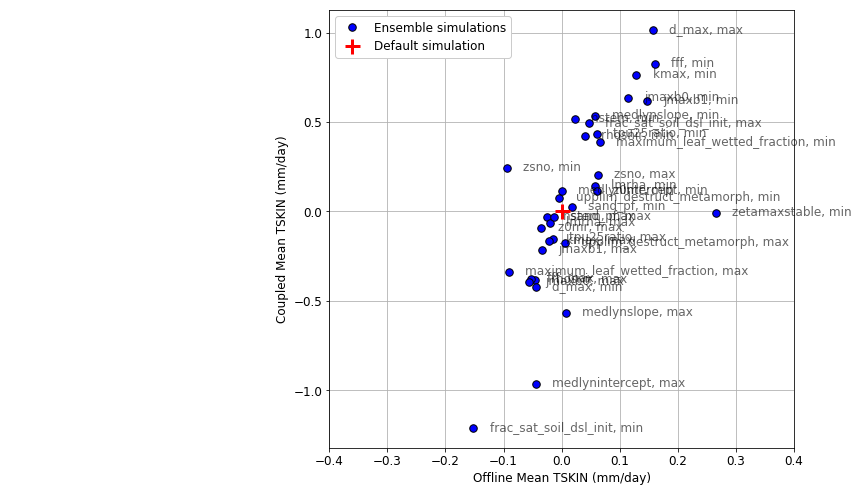

In [71]:
plt.rcParams.update({'font.size': 12})
plt_text=True
plot_1to1_line=False

plt.figure(figsize=(15,7))
#plt.subplot(1,2,1)


##################################
minval=np.nanmin([np.nanmin(global_mean_offline_unitconv), 
                  np.nanmin(global_mean_coupled_unitconv)])
if minval<0:
    minval=minval*(1+buffer_limits)
else:
    minval=minval*(1-buffer_limits)
maxval=np.nanmax([np.nanmax(global_mean_offline_unitconv), 
                  np.nanmax(global_mean_coupled_unitconv)])*(1+buffer_limits)
valrange=maxval-minval
text_offset=valrange/80
print(minval)
print(maxval)
    
##########################
ax=plt.gca()
vertices1 = np.array([[maxval,0],[maxval,maxval],[0,0]])
vertices2 = np.array([[minval,0],[minval,minval],[0,0]])
vertices3 = np.array([[0,maxval],[maxval,maxval],[0,0]])
vertices4 = np.array([[0,minval],[minval,minval],[0,0]])

if plot_1to1_line:
    patches = []
    triangle1 = Polygon(vertices1, color='mediumblue',alpha=0.1, closed=True)
    ax.add_patch(triangle1)
    triangle2 = Polygon(vertices2, color='mediumblue',alpha=0.1, closed=True)
    ax.add_patch(triangle2)
    triangle3 = Polygon(vertices3, color='salmon',alpha=0.1, closed=True)
    ax.add_patch(triangle3)
    triangle4 = Polygon(vertices4, color='salmon',alpha=0.1, closed=True)
    ax.add_patch(triangle4)
    plt.axhline(y=0, linestyle='--',color='k',linewidth=3)
    plt.axvline(x=0, linestyle='--',color='k',linewidth=3)

    plt.plot([minval, maxval],
             [minval, maxval],'-k', linewidth=3, label='1:1 line')
    plt.xlim([minval, maxval])
    plt.ylim([minval, maxval])

################

plt.plot(np.array(global_mean_offline_unitconv), 
         np.array(global_mean_coupled_unitconv), '.')

# Annotate
for i,key in enumerate(keys):
    label=crosswalk.description.values[i]
    if plt_text: plt.annotate(label,
             (global_mean_offline_unitconv[i]+text_offset,
              global_mean_coupled_unitconv[i]-text_offset/2),alpha=0.6, fontsize=12)
    
plt.plot(np.array(global_mean_offline_unitconv)[:-1],
         np.array(global_mean_coupled_unitconv)[:-1], '.b', markersize=15,        markeredgecolor='k',
        label='Ensemble simulations')
plt.plot(0, 
         0, '+r', markeredgewidth=3, markersize=15,
        label='Default simulation')
plt.legend(fontsize=12, framealpha=1)
plt.xlim([-0.4, 0.4])

# Format subplot
plt.grid()
plt.xlabel('Offline Mean '+var+' ('+units_converted+')')#, fontsize=14)
plt.ylabel('Coupled Mean '+var+' ('+units_converted+')')#, fontsize=14)
#plt.title('Global Offline vs. Coupled Land '+var)#, fontsize=14)
plt.tight_layout()
plt.savefig('Global_Offline_vs_Coupled_Land_'+var+'.png')

In [ ]:
np.nanmax(global_mean_coupled_unitconv)-np.nanmin(global_mean_coupled_unitconv)

In [48]:
buffer_limits=0.0001

In [57]:
crosswalk.where(crosswalk.param=='zetamaxstable')

key_CLM5PPE          param minmax include parameter domain  \
1          NaN            NaN    NaN     NaN              NaN   
2          NaN            NaN    NaN     NaN              NaN   
3          NaN            NaN    NaN     NaN              NaN   
4          NaN            NaN    NaN     NaN              NaN   
5          NaN            NaN    NaN     NaN              NaN   
6          NaN            NaN    NaN     NaN              NaN   
7          NaN            NaN    NaN     NaN              NaN   
8          NaN            NaN    NaN     NaN              NaN   
9          NaN            NaN    NaN     NaN              NaN   
10         NaN            NaN    NaN     NaN              NaN   
11         NaN            NaN    NaN     NaN              NaN   
12         NaN            NaN    NaN     NaN              NaN   
13         NaN            NaN    NaN     NaN              NaN   
14         NaN            NaN    NaN     NaN              NaN   
15         NaN            NaN    NaN     NaN              NaN   
16         NaN            NaN    NaN     NaN              NaN   
17         NaN            NaN    NaN     NaN              NaN   
18         NaN            NaN    NaN     NaN              NaN   
19         NaN            NaN    NaN     NaN              NaN   
20         NaN            NaN    NaN     NaN              NaN   
21         NaN            NaN    NaN     NaN              NaN   
22         NaN            NaN    NaN     NaN              NaN   
23         NaN            NaN    NaN     NaN              NaN   
24         NaN            NaN    NaN     NaN              NaN   
25         NaN            NaN    NaN     NaN              NaN   
26         NaN            NaN    NaN     NaN              NaN   
27         NaN            NaN    NaN     NaN              NaN   
28         NaN            NaN    NaN     NaN              NaN   
29         NaN            NaN    NaN     NaN              NaN   
30         NaN            NaN    NaN     NaN              NaN   
31         NaN            NaN    NaN     NaN              NaN   
32         NaN            NaN    NaN     NaN              NaN   
33         NaN            NaN    NaN     NaN              NaN   
34         NaN            NaN    NaN     NaN              NaN   
35    OAAT0042  zetamaxstable    min     yes              NaN   
36    OAAT0043  zetamaxstable    max     yes              NaN   

                                 parameter category  \
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
5                                               NaN   
6                                               NaN   
7                                               NaN   
8                                               NaN   
9                                               NaN   
10                                              NaN   
11                                              NaN   
12                                              NaN   
13                                              NaN   
14                                              NaN   
15                                              NaN   
16                                              NaN   
17                                              NaN   
18                                              NaN   
19                                              NaN   
20                                              NaN   
21                                              NaN   
22                                              NaN   
23                                              NaN   
24                                              NaN   
25                                              NaN   
26                                              NaN   
27                                              NaN   
28                                              NaN   
29

In [58]:
keys

array(['0001', '0037', '0007', '0008', '0009', '0010', '0013', '0014',
       '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022',
       '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030',
       '0031', '0032', '0033', '0034', '0035', '0036', '0003', '0004',
       '0005', '0006', '0011', '0012'], dtype=object)

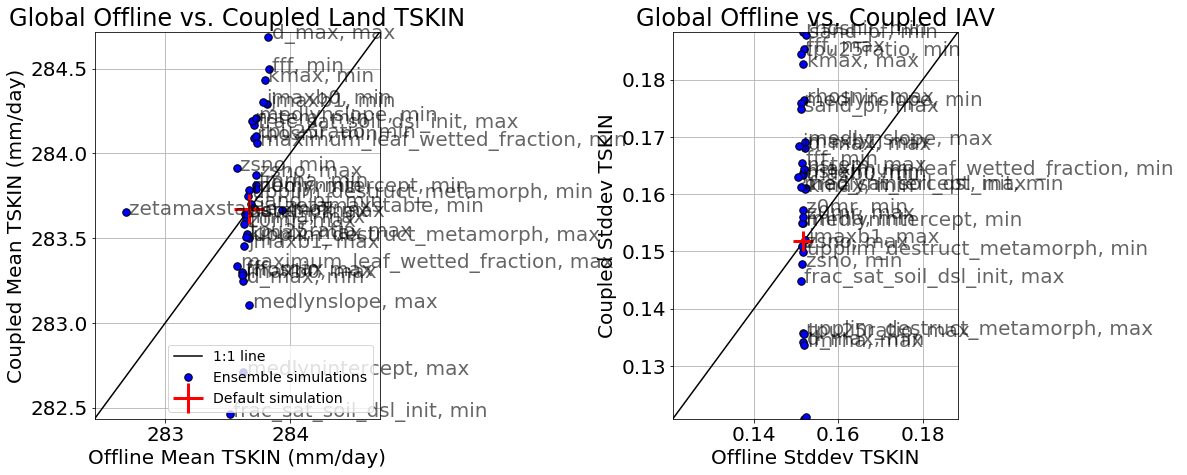

In [53]:
plt.rcParams.update({'font.size': 20})
plt_text=True

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)

minval=np.nanmin([np.nanmin(global_mean_offline), 
                  np.nanmin(global_mean_coupled)])*unitconv*(1-buffer_limits)
maxval=np.nanmax([np.nanmax(global_mean_offline), 
                  np.nanmax(global_mean_coupled)])*unitconv*(1+buffer_limits)
valrange=maxval-minval
text_offset=valrange/80

if plot_1to1_line:
    plt.plot([minval, maxval],
             [minval, maxval],'-k', label='1:1 line')
    plt.xlim([minval, maxval])
    plt.ylim([minval, maxval])

plt.plot(np.array(global_mean_offline)*unitconv, 
         np.array(global_mean_coupled)*unitconv, '.')

# Annotate
for i,key in enumerate(keys):
    label=crosswalk.description.values[i]
    if plt_text: plt.annotate(label,
             (global_mean_offline[i]*unitconv+text_offset,
              global_mean_coupled[i]*unitconv-text_offset/2),alpha=0.6)
    
plt.plot(np.array(global_mean_offline)[:-1]*unitconv,
         np.array(global_mean_coupled)[:-1]*unitconv, '.b', markersize=15,        markeredgecolor='k',
        label='Ensemble simulations')
plt.plot(np.array(global_mean_coupled)[-1]*unitconv, 
         np.array(global_mean_coupled)[-1]*unitconv, '+r', markeredgewidth=3, markersize=30,
        label='Default simulation')
plt.legend(fontsize=14)

# Format subplot
plt.grid()
plt.xlabel('Offline Mean '+var+' ('+units_converted+')')#, fontsize=14)
plt.ylabel('Coupled Mean '+var+' ('+units_converted+')')#, fontsize=14)
plt.title('Global Offline vs. Coupled Land '+var)#, fontsize=14)

##################################################################################

plt.subplot(1,2,2)
text_offset=0.00001
outlier_filter=((keys!='0012')&(keys!='0011'))

minval=np.nanmin([np.nanmin(global_iav_offline), np.nanmin(global_iav_coupled)])*unitconv*(1-buffer_limits)
maxval=np.nanmax([np.nanmax(global_iav_offline), np.nanmax(global_iav_coupled)])*unitconv*(1+buffer_limits)
valrange=maxval-minval
text_offset=valrange/80

if plot_1to1_line: 
    plt.plot([minval, maxval],[minval, maxval],'-k')
    plt.xlim([minval, maxval])
    plt.ylim([minval, maxval])

plt.plot(np.array(global_iav_offline)[:-1][outlier_filter]*unitconv, 
         np.array(global_iav_coupled)[:-1][outlier_filter]*unitconv, '.')

# Annotate
for i,key in enumerate(keys):
    label=crosswalk.description.values[i]
    if outlier_filter[i]==True:
        testind=1
        if plt_text: plt.annotate(label,
             (global_iav_offline[i]*unitconv+text_offset,
              global_iav_coupled[i]*unitconv-text_offset/2),alpha=0.6)

plt.plot(np.array(global_iav_offline)[:-1][outlier_filter]*unitconv, 
         np.array(global_iav_coupled)[:-1][outlier_filter]*unitconv, 'b.', markersize=15,
        markeredgecolor='k')

plt.plot(np.array(global_iav_offline)[-1]*unitconv, 
         np.array(global_iav_coupled)[-1]*unitconv, '+r', markeredgewidth=3,markersize=20)

# Format subplot
plt.grid()
plt.xlabel('Offline Stddev '+var)
plt.ylabel('Coupled Stddev '+var)
plt.title('Global Offline vs. Coupled IAV')


plt.tight_layout()
plt.savefig('figures/'+var+'_scatterplots.png')

# Make IAV and mean plots by latitude

### Plot settings

In [28]:
plot_1to1_line=True
buffer_limits=0.05
unitconv=86400*365/1e15
units_converted = 'PgC/yr'
aggregation_method='iav'

In [29]:
num_ensemblemembers = np.shape(ensemble_coupled)[0]
latmins=np.arange(-90,90,10)
num_latranges = np.size(latmins)

### Do calculations

In [30]:
# empty arrays for 
coupled_ensemble_bylat = np.zeros([num_ensemblemembers, num_latranges])
coupled_ensemble_bylat[:]=np.nan
offline_ensemble_bylat = np.zeros([num_ensemblemembers, num_latranges])
offline_ensemble_bylat[:]=np.nan
for j, ds_coupled in enumerate(ensemble_coupled):
    # Define which offline simulation corresponds to this coupled simulation
    ds_offline=ensemble_offline[j]
    print(j)
    
    # Loop through latitudes
    for i, latmin in enumerate(latmins):
        latmax=latmin+10
        
        # define land area for this latitude band
        landarea_thissubset=subset_landarea(latmax, latmin)
        
        # calculate annual total across this latitude ban
        coupled_annual_thissubset=calculate_sum(ds_coupled[var], landarea=landarea_thissubset)
        offline_annual_thissubset=calculate_sum(ds_offline[var], landarea=landarea_thissubset)
        
        # aggregate annual values (standard deviation captures interannual variability)
        if aggregation_method=='mean':
            coupled_iav=coupled_annual_thissubset.mean(dim='year')
            offline_iav=offline_annual_thissubset.mean(dim='year')
        elif aggregation_method=='iav':
            coupled_iav=coupled_annual_thissubset.std(dim='year')
            offline_iav=offline_annual_thissubset.std(dim='year')
        
        # add to arrays
        coupled_ensemble_bylat[j,i]=coupled_iav
        offline_ensemble_bylat[j,i]=offline_iav


0


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

1


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

2


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

3


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

4


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

5


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

6


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

7


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

8


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

9


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

10


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

11


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

12


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

13


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

14


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

15


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

16


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

17


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

18


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

19


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

20


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

21


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

22


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

23


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

24


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

25


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

26


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

27


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

28


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

29


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

30


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

31


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

32


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

33


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

34


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

35


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

36


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Make figure

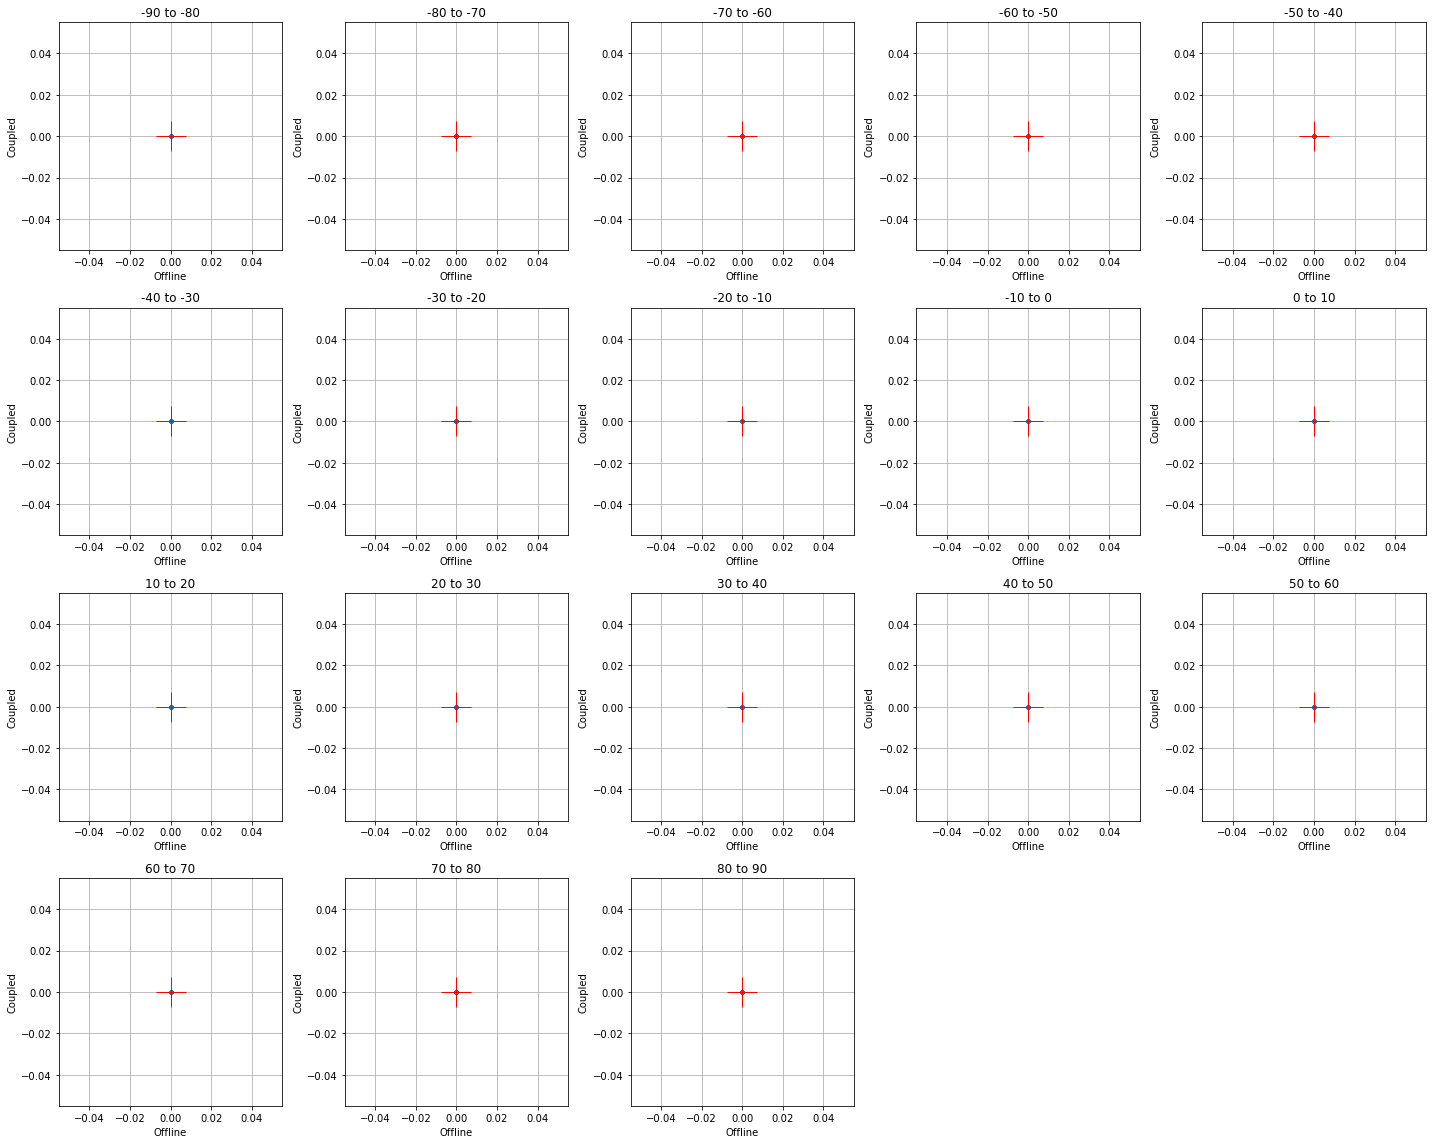

In [32]:
plt.figure(figsize=(20,16))
for i, latmin in enumerate(latmins):
    plt.subplot(4,5,i+1)
    
    # Get data for a single latitude band
    coupled_vals=coupled_ensemble_bylat[:,i]*unitconv
    offline_vals=offline_ensemble_bylat[:,i]*unitconv
    
    # Plot data for this latitude band
    plt.plot(offline_vals,coupled_vals, '.')
    plt.plot(offline_vals[-1],coupled_vals[-1], '+r', markersize=30)
    
    # Plot 1:1 line
    if plot_1to1_line: 
        # Calculate range of values (for axes limits and 1:1 line)
        buffer_limits=0.05
        minval=0#np.nanmin([np.nanmin(offline_vals), np.nanmin(coupled_vals)])*(1-buffer_limits)
        maxval=0.85#np.nanmax([np.nanmax(offline_vals), np.nanmax(coupled_vals)])*(1+buffer_limits)
        
        # Plot 1:1 line
        #plt.plot([minval, maxval],[minval, maxval],'-k')
        #plt.xlim([minval, maxval])
        #plt.ylim([minval, maxval])
    
    # Format and label subplot
    plt.xlabel('Offline')
    plt.ylabel('Coupled')
    plt.title(str(latmin)+ ' to '+str(latmin+10))
    plt.grid()
    
plt.tight_layout()
plt.savefig('figures/'+var+'_'+aggregation_method+'_bylatitude.png')

# Compare global averages

In [22]:
ds[var].units #gC/m2/s to #kgC/m2/yr

'gC/m^2/s'

In [23]:
plot_1to1_line=True

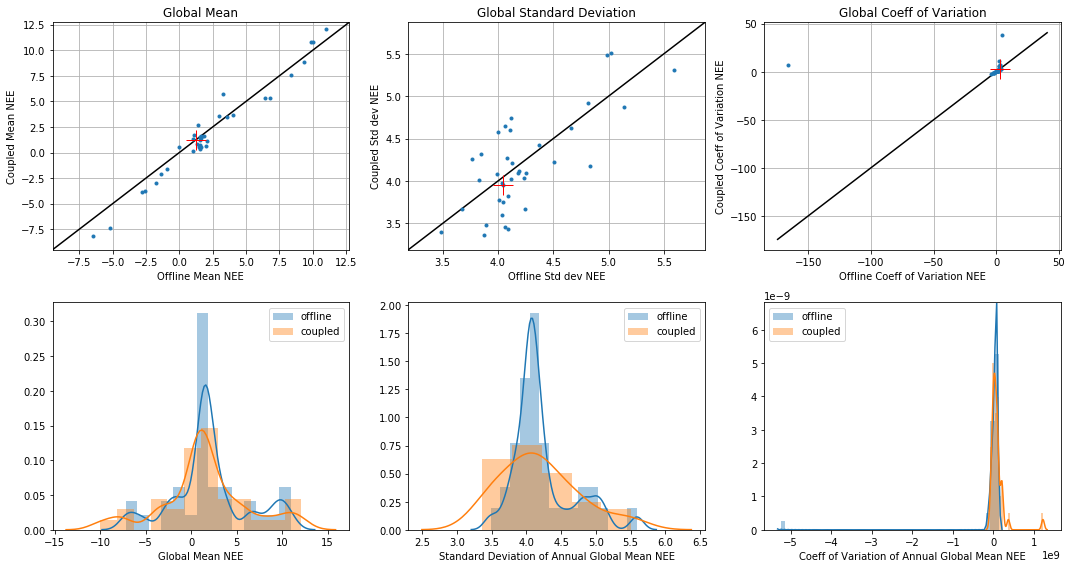

In [24]:
unitconv=86400*365#/1000

buffer_limits=0.05
plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
minval=np.nanmin([np.nanmin(global_mean_offline), np.nanmin(global_mean_coupled)])*unitconv*(1-buffer_limits)
maxval=np.nanmax([np.nanmax(global_mean_offline), np.nanmax(global_mean_coupled)])*unitconv*(1+buffer_limits)
if plot_1to1_line: plt.plot([minval, maxval],[minval, maxval],'-k')
plt.plot(np.array(global_mean_offline)*unitconv, 
         np.array(global_mean_coupled)*unitconv, '.')
plt.plot(np.array(global_mean_coupled)[-1]*unitconv, 
         np.array(global_mean_coupled)[-1]*unitconv, '+r', markersize=20)
plt.grid()
#for i,key in enumerate(keys):
#    plt.text(np.array(global_mean_offline)[i]*unitconv, 
#         np.array(global_mean_coupled)[i]*unitconv,key)
plt.xlabel('Offline Mean '+var)
plt.ylabel('Coupled Mean '+var)
if plot_1to1_line: plt.xlim([minval, maxval])
if plot_1to1_line: plt.ylim([minval, maxval])
plt.title('Global Mean')

plt.subplot(2,3,2)
minval=np.nanmin([np.nanmin(global_iav_offline), np.nanmin(global_iav_coupled)])*unitconv*(1-buffer_limits)
maxval=np.nanmax([np.nanmax(global_iav_offline), np.nanmax(global_iav_coupled)])*unitconv*(1+buffer_limits)
if plot_1to1_line: plt.plot([minval, maxval],[minval, maxval],'-k')
plt.plot(np.array(global_iav_offline)*unitconv, 
         np.array(global_iav_coupled)*unitconv, '.')
plt.plot(np.array(global_iav_offline)[-1]*unitconv, 
         np.array(global_iav_coupled)[-1]*unitconv, '+r', markersize=20)
plt.xlabel('Offline Std dev '+var)
plt.ylabel('Coupled Std dev '+var)
plt.title('Global Standard Deviation')
if plot_1to1_line: plt.xlim([minval, maxval])
if plot_1to1_line: plt.ylim([minval, maxval])
plt.grid()

plt.subplot(2,3,3)
minval=np.nanmin([np.nanmin(global_coeffvar_offline), np.nanmin(global_coeffvar_coupled)])
if minval<1:
    minval=minval*(1+buffer_limits)
else:
    minval=minval*(1-buffer_limits)
maxval=np.nanmax([np.nanmax(global_coeffvar_offline), np.nanmax(global_coeffvar_coupled)])*(1+buffer_limits)
if plot_1to1_line: plt.plot([minval, maxval],[minval, maxval],'-k')
plt.plot(np.array(global_coeffvar_offline), 
         np.array(global_coeffvar_coupled), '.')
plt.plot(np.array(global_coeffvar_offline)[-1], 
         np.array(global_coeffvar_coupled)[-1], '+r', markersize=20)
plt.xlabel('Offline Coeff of Variation '+var)
plt.ylabel('Coupled Coeff of Variation '+var)
plt.title('Global Coeff of Variation')
#if plot_1to1_line: plt.xlim([minval, maxval])
#if plot_1to1_line: plt.ylim([minval, maxval])
plt.grid()

plt.subplot(2,3,4)
sns.distplot(np.array(global_mean_offline)*unitconv, label='offline')
sns.distplot(np.array(global_mean_coupled)[~np.isnan(global_mean_coupled)]*unitconv, label='coupled')
plt.legend()
plt.xlabel('Global Mean '+ var)

plt.subplot(2,3,5)
sns.distplot(np.array(global_iav_offline)*unitconv, label='offline')
sns.distplot(np.array(global_iav_coupled)[~np.isnan(global_mean_coupled)]*unitconv, label='coupled')
plt.legend()
plt.xlabel('Standard Deviation of Annual Global Mean '+ var)

plt.subplot(2,3,6)
sns.distplot(np.array(global_coeffvar_offline)*unitconv, label='offline')
sns.distplot(np.array(global_coeffvar_coupled)*unitconv, label='coupled')
plt.legend()
plt.xlabel('Coeff of Variation of Annual Global Mean '+ var)

plt.tight_layout()
plt.savefig(var+'_global_offline_coupled_comparison.png')

# GLobal averages plot

# Make maps

In [18]:
diffs_offline=[]
for i, ensemble_data in enumerate(ensemble_offline[:-1]):
    ds=ensemble_offline[i][var][60*12:,:,:].mean(dim='time')
    diff=ds-ref
    diffs_offline.append(diff.load())

diffs_coupled=[]
for i, ensemble_data in enumerate(ensemble_coupled[:-1]):
    ds=ensemble_coupled[i][var][60*12:,:,:].mean(dim='time')
    diff=ds-ref
    diffs_coupled.append(diff.load())

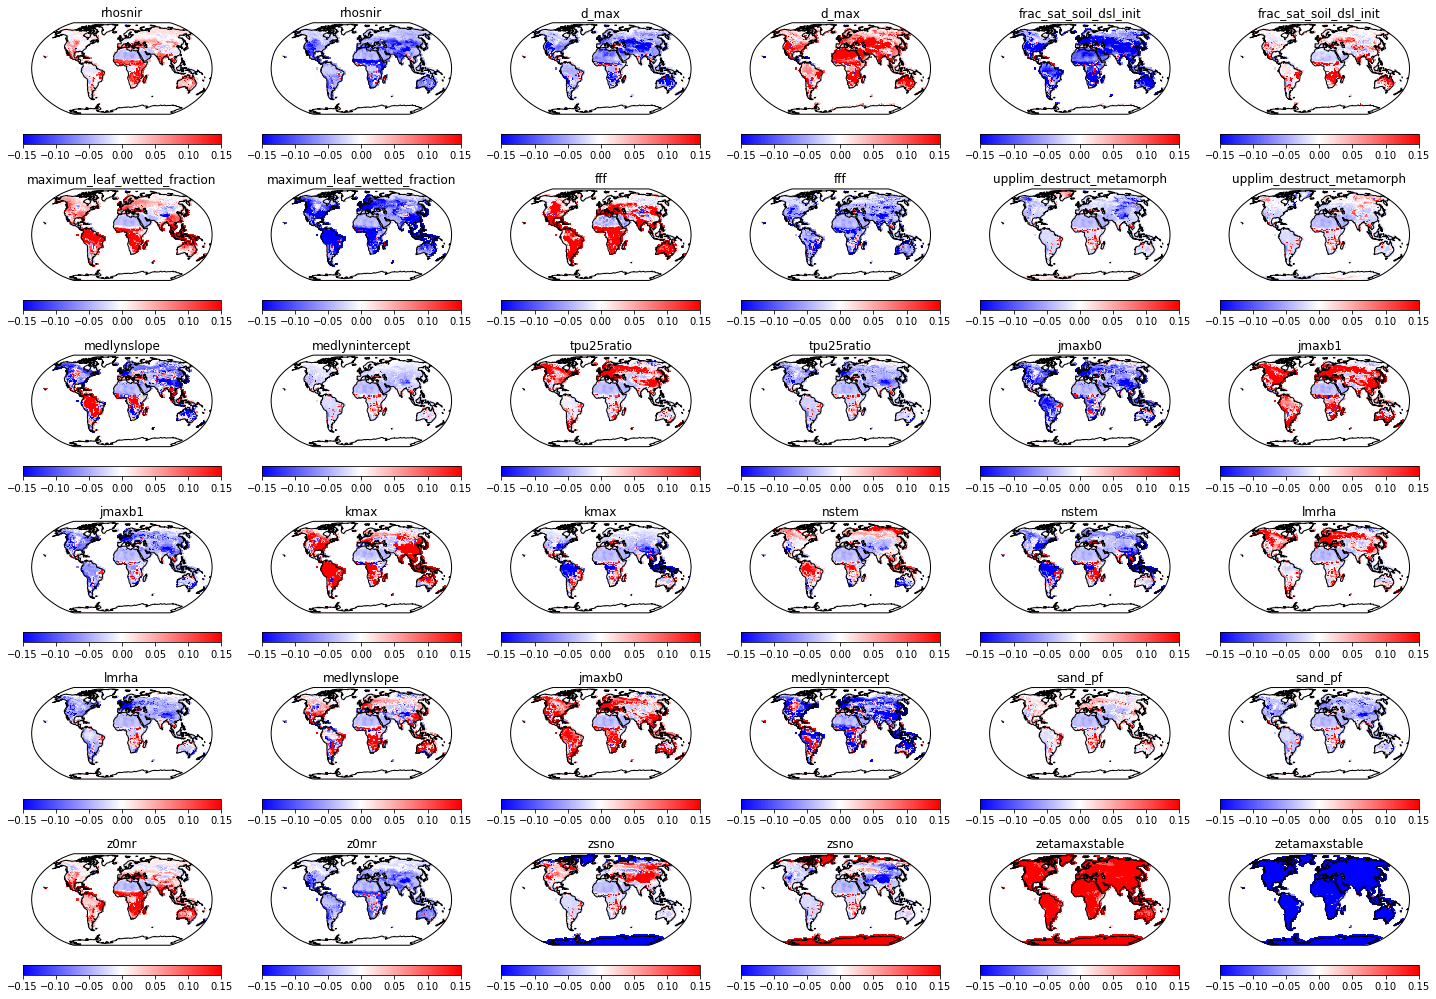

In [19]:
ref=basecase_lnd_offline[var][60*12:,:,:].mean(dim='time')

plt.figure(figsize=(20,14))

for i, mapdata in enumerate(diffs_offline):
    #print(i)

    ax=plt.subplot(6,6,i+1, projection=ccrs.Robinson())
    #ax = plt.axes()
    ax.coastlines()
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

    plt.pcolormesh(cyclic_lons, mapdata.lat, 
                   cyclic_data, 
                   cmap=plt.cm.bwr, vmin=-0.15, vmax=0.15,#
                   transform=ccrs.PlateCarree())
    plt.colorbar(orientation='horizontal')
    plt.title(crosswalk.param.values[i])
plt.tight_layout()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


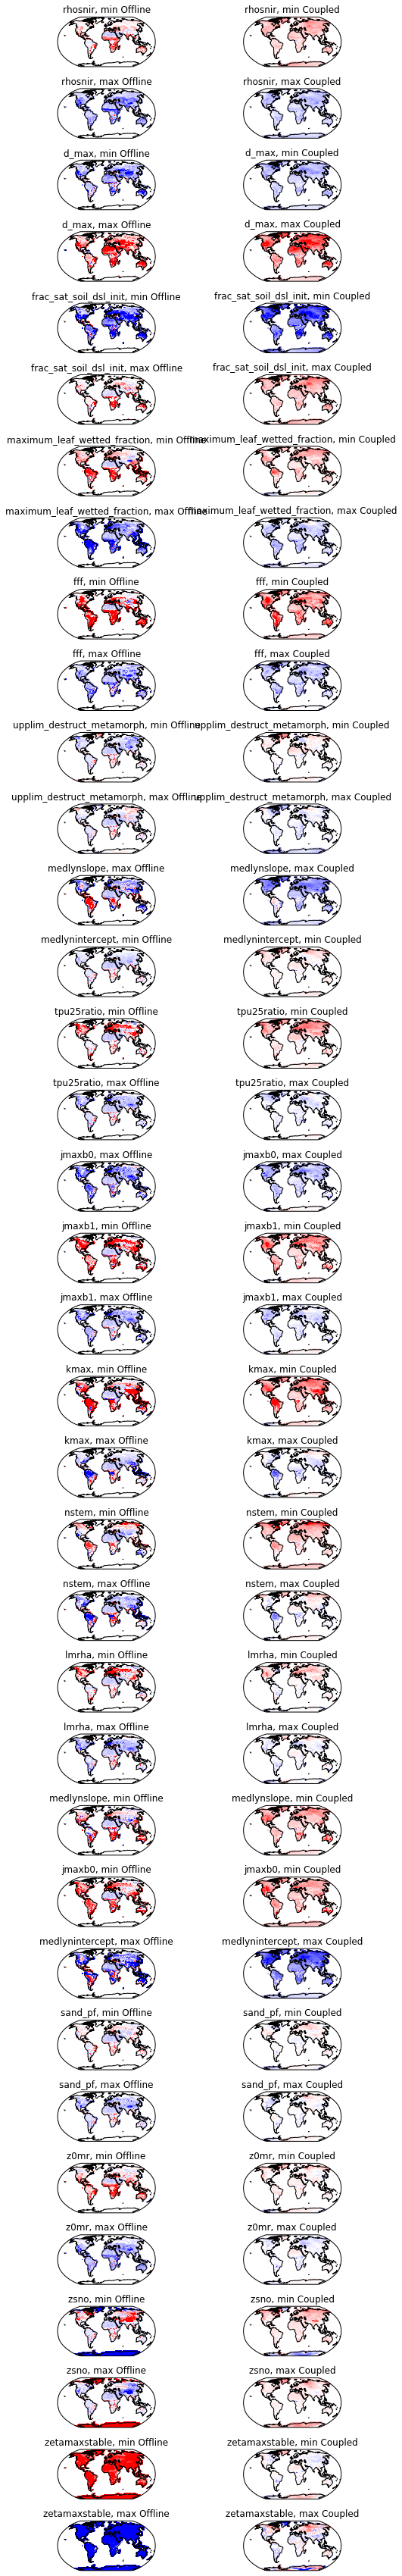

In [73]:
ref=basecase_lnd_offline[var][60*12:,:,:].mean(dim='time')

plt.figure(figsize=(7,50))


for i, mapdata in enumerate(diffs_offline):
    print(i)
    ax=plt.subplot(38,2,2*(i+1)-1, projection=ccrs.Robinson())
    #ax = plt.axes()
    ax.coastlines()
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

    plt.pcolormesh(cyclic_lons, mapdata.lat, 
                   cyclic_data, 
                   cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2,#
                   transform=ccrs.PlateCarree())
    plt.title(crosswalk.description.values[i]+" Offline",fontsize=12)
    #plt.colorbar(orientation='horizontal')
    
    #ds=ensemble_coupled[i][var][60*12:,:,:].mean(dim='time')
    mapdata=diffs_coupled[i]
    ax=plt.subplot(38,2,2*(i+1), projection=ccrs.Robinson())
    #ax = plt.axes()
    ax.coastlines()
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

    plt.pcolormesh(cyclic_lons, mapdata.lat, 
                   cyclic_data, 
                   cmap=plt.cm.bwr, vmin=-2, vmax=2,#
                   transform=ccrs.PlateCarree())
    #plt.colorbar(orientation='horizontal')
    plt.title(crosswalk.description.values[i]+" Coupled",fontsize=12)
plt.tight_layout()
plt.savefig('Offline_vs_Coupled.png')

# Other plots

/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

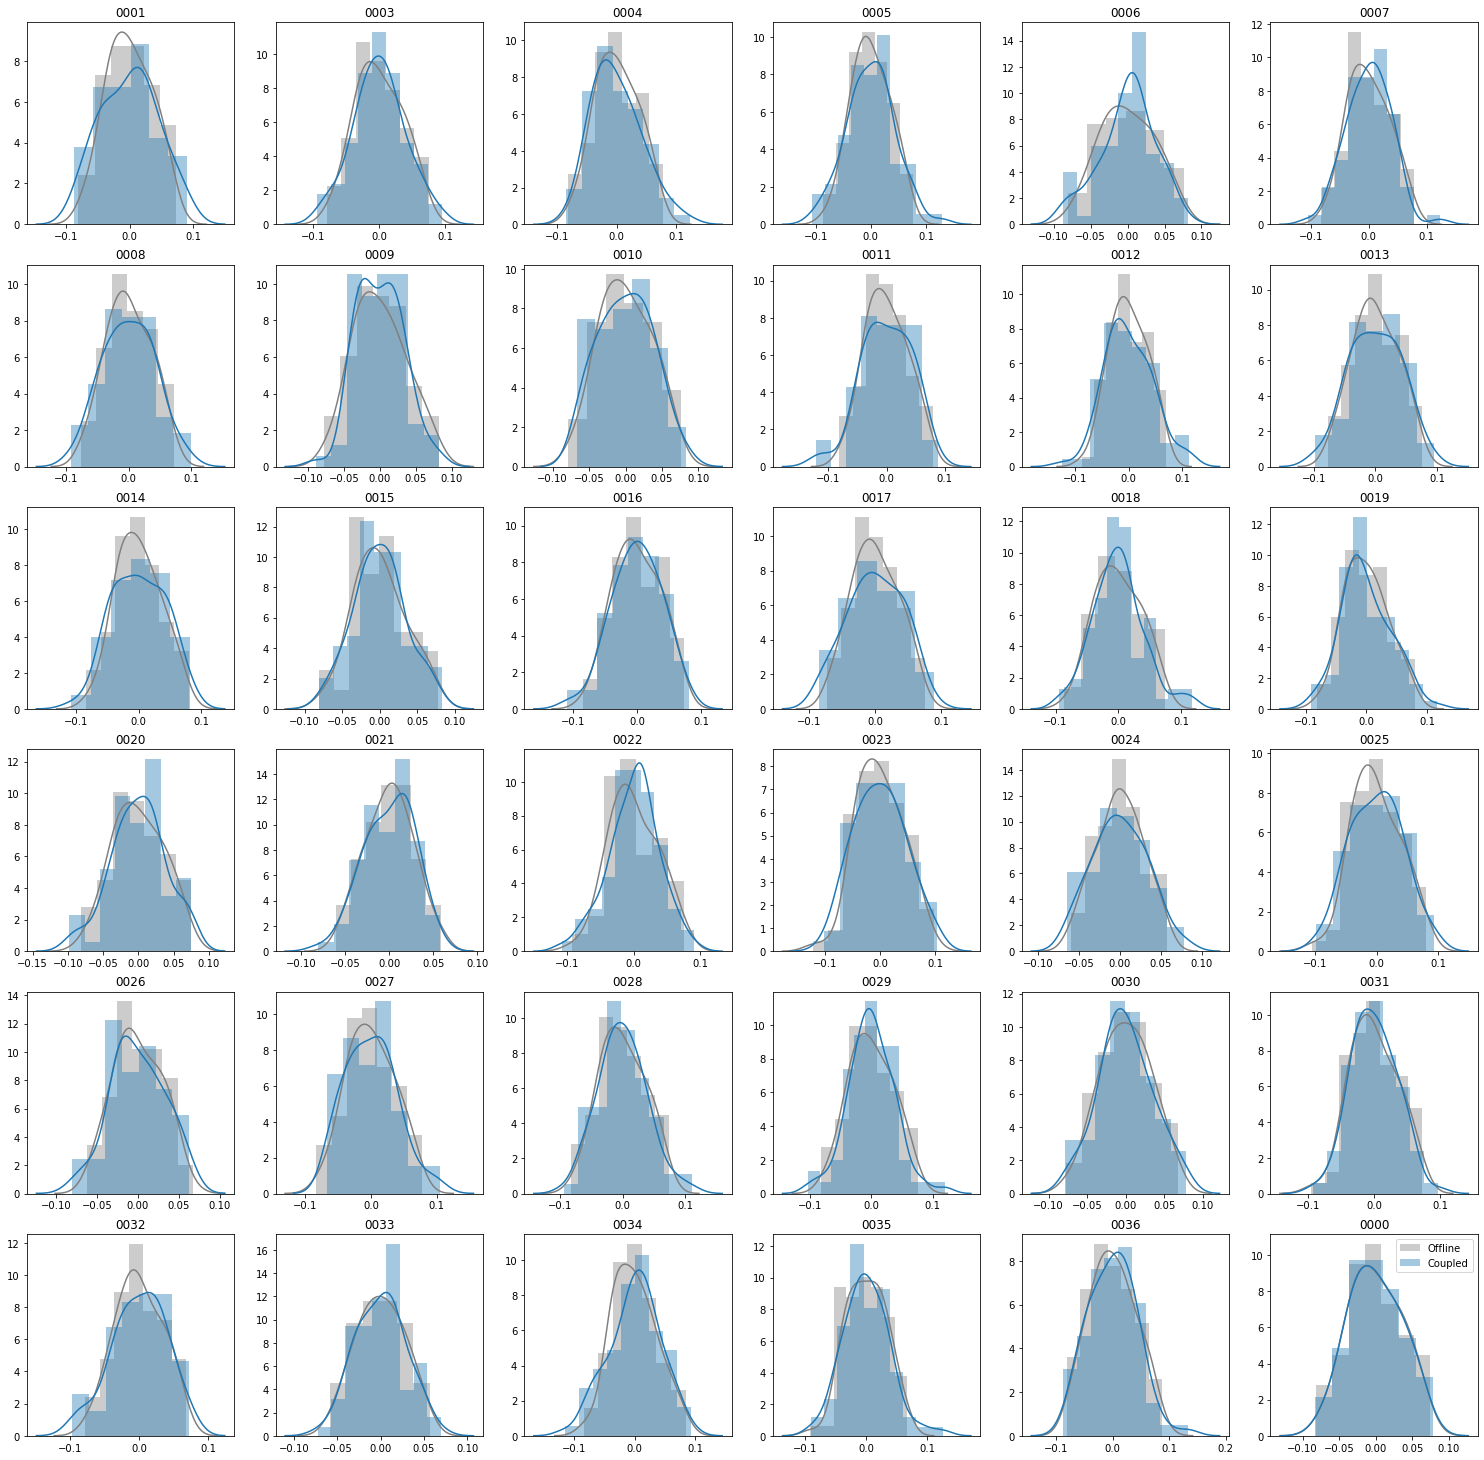

In [82]:
plt.figure(figsize=(26,26))
for i, ds in enumerate(ensemble_coupled):
    key=keys[i]
    ds_offline=ensemble_offline[i]
    ds_annual_global_coupled=calculate_mean(ds[var])
    ds_annual_global_offline=calculate_mean(ds_offline[var])
    ds_annual_global_coupled=ds_annual_global_coupled-np.nanmean(ds_annual_global_coupled)
    ds_annual_global_offline=ds_annual_global_offline-np.nanmean(ds_annual_global_offline)
    plt.subplot(6,6,i+1)
    sns.distplot(ds_annual_global_offline*86400, color='gray',label='Offline')
    sns.distplot(ds_annual_global_coupled*86400, label='Coupled')
    plt.title(key)
plt.legend()

In [ ]:
plt.figure(figsize=(26,26))
for i, ds in enumerate(ensemble_coupled):
    key=keys[i]
    ds_offline=ensemble_offline[i]
    ds_annual_global_coupled=calculate_mean(ds[var])
    ds_annual_global_offline=calculate_mean(ds_offline[var])
    ds_annual_global_coupled=ds_annual_global_coupled-np.nanmean(ds_annual_global_coupled)
    ds_annual_global_offline=ds_annual_global_offline-np.nanmean(ds_annual_global_offline)
    plt.subplot(6,6,i+1)
    plt.plot(ds_annual_global_coupled*unitconv,'.--r', label='Coupled')
    plt.plot(ds_annual_global_offline*unitconv,'.-k', label='Offline')
    
    std_diff=(global_iav_coupled[i]*unitconv-global_iav_offline[i]*unitconv)

    plt.title(key+',   '+str(np.round(std_diff,3)))
plt.legend()

/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3

# Make plots of changes for each point

In [194]:
ref_flat=basecase_lnd_coupled[var].mean(dim='time').stack(gridcell=['lat', 'lon']).load()

0


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


3


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


4


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


5


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


6


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


7


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


8


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


9


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


10


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


11


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


12


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


13


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


14


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


15


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


16


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


17


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


18


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


19


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


20


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


21


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


22


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


23


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


24


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


25


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


26


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


27


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


28


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


29


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


30


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


31


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


32


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


33


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


34


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


35


/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


TypeError: 'NoneType' object is not subscriptable

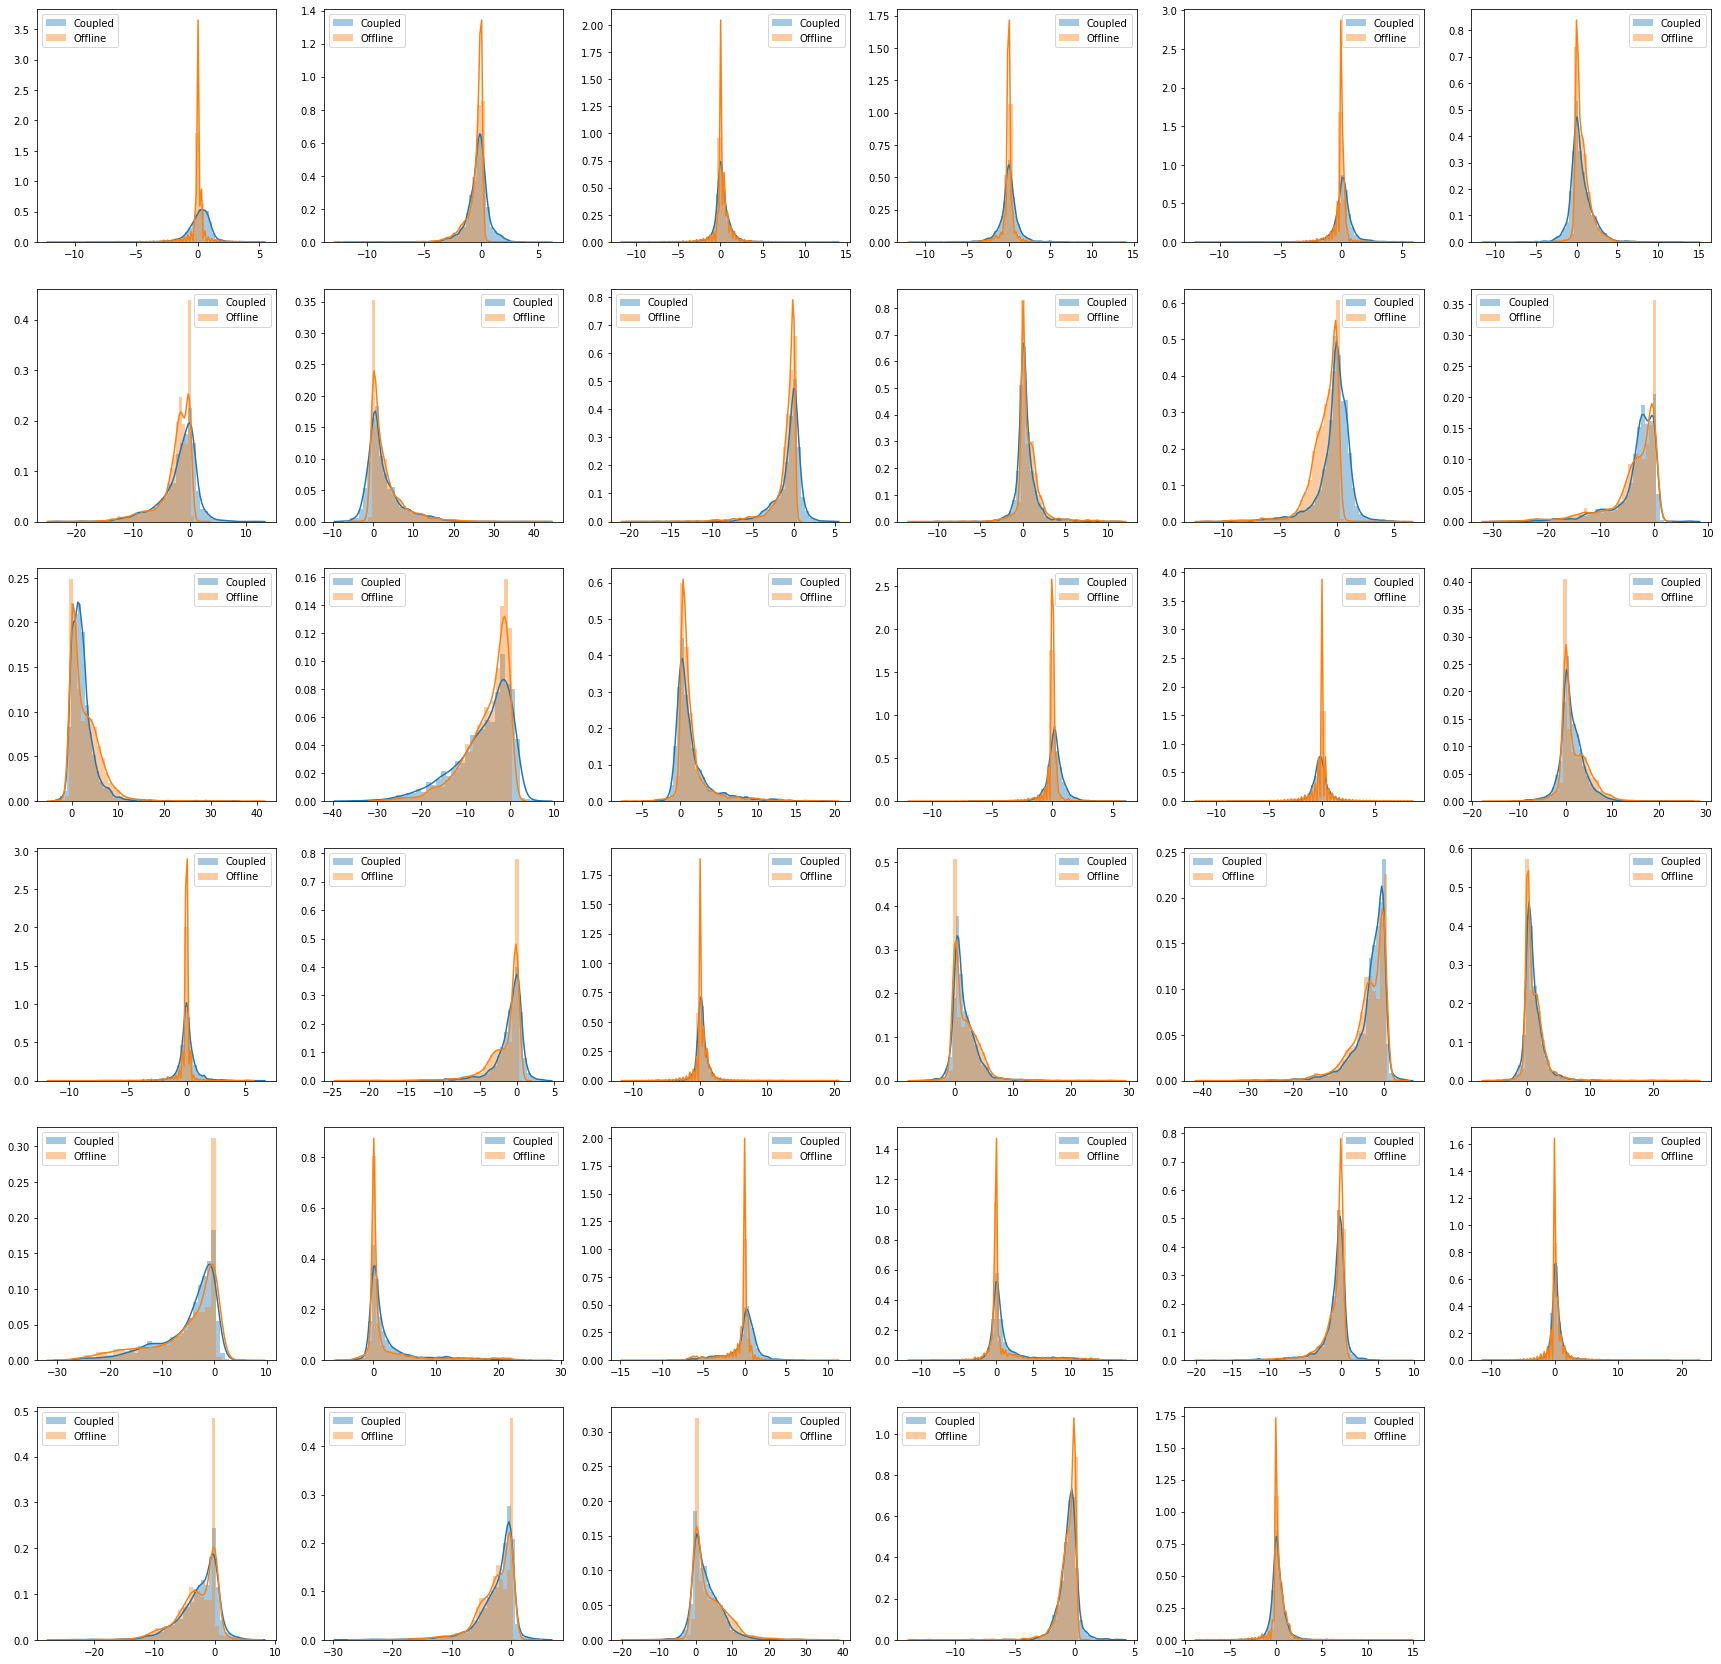

In [144]:
plt.figure(figsize=(30,30))
point_filter=(np.abs(ref_flat.lat)<60)&(~np.isnan(ref_flat))
for i, ds in enumerate(ensemble_coupled):
    print(i)
    ds_flat=ds[var].mean(dim='time').stack(gridcell=['lat', 'lon'])
    ds_offline=ensemble_offline[i]
    ds_flat_offline=ds_offline[var].mean(dim='time').stack(gridcell=['lat', 'lon'])
    delta_coupled=ds_flat-ref_flat
    delta_offline=ds_flat_offline-ref_flat
    plt.subplot(6,6,i+1)
    sns.distplot(delta_coupled.values[point_filter], label='Coupled')
    sns.distplot(delta_offline.values[point_filter], label='Offline')
    plt.legend()